# 1. Learning Bounds Decision Trees:

In [29]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.tree import DecisionTreeClassifier

In [30]:
df = pd.read_csv('mnist.csv')   # read the csv file 

df_feat = df.drop('label',axis=1) # drop the label column

label_y = df['label'] # label column

In [45]:
def compute_empirical_risk(y_true, y_pred, n_classes):
    """
    Computes the empirical risk of a decision tree classifier.
    
    Args:
    - y_true (numpy.ndarray): True labels of the samples (shape: (n_samples,))
    - y_pred (numpy.ndarray): Predicted labels of the samples (shape: (n_samples,))
    - n_classes (int): Number of classes in the classification problem
    
    Returns:
    - empirical_risk (float): Empirical risk of the decision tree classifier
    """
    n_samples = len(y_true)
    class_counts = np.zeros(n_classes)
    for c in range(n_classes):
        class_counts[c] = np.sum(y_true == c)
    class_probs = class_counts / n_samples
    error = 0
    for c in range(n_classes):
        mask = (y_true == c)
        error += np.sum(mask * (y_pred != c)) / np.sum(mask)
    empirical_risk = np.sum(error * class_probs)
    return empirical_risk

In [51]:
print("Train Size: ",0.90)
X_train,X_test,Y_train,Y_test = train_test_split(df_feat,label_y,test_size=0.1,random_state=72)       # split the data into train and test

clf = DecisionTreeClassifier()      # create the decision tree classifier

path = clf.cost_complexity_pruning_path(X_train,Y_train)    # find the ccp_alphas and impurities

ccp_alphas, impurities = path.ccp_alphas, path.impurities   # store the ccp_alphas and impurities

clf = DecisionTreeClassifier(ccp_alpha=3e-07)    # create the decision tree classifier with ccp_alpha
clf.fit(X_train,Y_train)

y_true = Y_test.values; # true labels
y_pred = clf.predict(X_test) # predicted labels
n_classes = 10; # number of classes

print("Empirical Risk: ",compute_empirical_risk(y_true, y_pred, n_classes))

Train Size:  0.9
Empirical Risk:  1.4870688747172036


In [52]:
n_nodes = clf.tree_.node_count
print("Number of nodes in the decision tree:", n_nodes)

n_samples = X_train.shape[0]
print("Number of samples used to train the decision tree:", n_samples)
print("Delta value:",0.1)

n_features = X_train.shape[1]
print("Number of features used to train the decision tree:", n_features)

Number of nodes in the decision tree: 5599
Number of samples used to train the decision tree: 37800
Delta value: 0.1
Number of features used to train the decision tree: 784


In [53]:
upper_bound = compute_empirical_risk(y_true, y_pred, n_classes) + np.sqrt( ( (n_nodes+1)*np.log(n_features+3) + np.log(2/0.1) )  / (2*n_samples)) # upper bound

print("Upper bound on the generalization error:", upper_bound)

Upper bound on the generalization error: 2.189907731998429


In [54]:
# probability of misclassification
print("Prob of Error:")
print(1 - classification_report(y_true, y_pred, output_dict=True)['accuracy'])

Prob of Error:
0.14714285714285713


# Learning Bound SVM:

In [40]:
from sklearn.svm import SVC

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df_feat,label_y,test_size=0.5) # split the data

model = SVC(C=10)                    # create the model
model.fit(X_train,y_train)           # fit the model

y_pred = model.predict(X_test)       # predict the labels
y_true = y_test.values             # true labels
n_classes = 10

n_samples = X_train.shape[0]
n_features = X_train.shape[1]

print("Number of samples used to train the SVM:", n_samples)
print("Number of features used to train the SVM:", n_features)
print("Empirical Risk:",compute_empirical_risk(y_true, y_pred, n_classes))
print("Delta value:",0.1)

upper_bound = compute_empirical_risk(y_true, y_pred, n_classes) + np.sqrt( (2*np.log(n_features+1))/n_samples ) + np.sqrt( np.log(1/0.1)/n_samples ) # upper bound
print("Upper bound on the generalization error:", upper_bound)

# probability of misclassification
print("Prob of Error:")
print(1 - classification_report(y_true, y_pred, output_dict=True)['accuracy'])

Number of samples used to train the SVM: 21000
Number of features used to train the SVM: 784
Empirical Risk: 0.24698316718896793
delta value: 0.1
Upper bound on the generalization error: 0.28265018306365824
Prob of Error:
0.02461904761904765


# 2.Mean Estimator MLE

In [22]:
df = pd.read_csv('DataSet_4.csv')   # read the csv file 

var1 = df.iloc[:,0].var()
var2 = df.iloc[:,1].var()

mean_1 = df.iloc[:,0].mean()
mean_2 = df.iloc[:,1].mean()

print("Variance of the first feature:",var1)
print("Variance of the second feature:",var2)

print("Mean: ",mean_1 ,mean_2)

Variance of the first feature: 1.0242647094382833
Variance of the second feature: 0.6814636803366799
Mean:  1.0002088782227145 2.9953452508881515


In [17]:
cov_matrix = np.array([[var1,0],[0,var2]]) # create the covariance matrix

print("Covariance Matrix:\n",cov_matrix)

Covariance Matrix:
 [[1.02426471 0.        ]
 [0.         0.68146368]]


In [24]:
import numpy as np
from scipy.optimize import minimize

# Generate some random data with two features
data = df

# Define the log-likelihood function for a multivariate Gaussian distribution
def log_likelihood(params, data):
    mean = [mean_1, mean_2]
    cov = cov_matrix
    log_prob = -0.5 * np.log(np.linalg.det(cov)) - 0.5 * np.sum(np.dot((data - mean), np.linalg.inv(cov)) * (data - mean), axis=1) - 0.5 * data.shape[1] * np.log(2 * np.pi)
    return -np.sum(log_prob)

# Use the minimize function from the scipy library to find the MLE of the mean
params_initial = np.concatenate((np.mean(data, axis=0), np.cov(data, rowvar=False).flatten()))
result = minimize(lambda params: log_likelihood(params, data), params_initial, method='L-BFGS-B')
mean_mle = result.x[:2]

# Print the MLE of the mean
print("MLE of the mean:", mean_mle)


MLE of the mean: [1.00020888 2.99534525]


# 3. Regression Functions 

In [25]:
# importing classifiers
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [26]:
# Generate the dataset
np.random.seed(0)
N = 100
X = np.sort(np.random.uniform(0, 3, N))
y = 2*np.sin(X) + np.random.normal(0, np.sqrt(0.25), N)

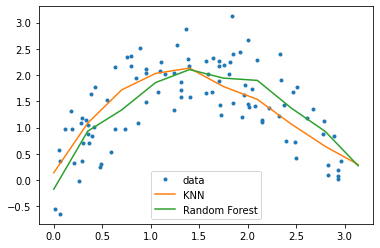

In [27]:
x_test = np.array([0, 0.35, 0.70, 1.05, 1.40, 1.75, 2.10, 2.45, 2.80, 3.14]).reshape(-1, 1)

# Fit the KNN regression model
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X.reshape(-1, 1), y)
y_knn = knn.predict(x_test)

# Fit the random forest regression model
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X.reshape(-1, 1), y)
y_rf = rf.predict(x_test)

# Plot the estimated regression function values
plt.plot(X, y, '.', label='data')
plt.plot(x_test, y_knn, '-', label='KNN')
plt.plot(x_test, y_rf, '-', label='Random Forest')
plt.legend()
plt.show()